# Imports, install and mount

In [147]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# # %pwd
# print("DRIVE MOUNTED")

<!--  -->

In [148]:
# ! pip install cuda
# ! pip install torch_geometric
# ! pip install nxontology
# ! pip install tensordict
# ! pip install pandas
# ! pip install tensorflow
# ! pip install scipy
# ! pip install matplotlib

import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader

from torch.nn.functional import normalize
from tensordict.tensordict import TensorDict
import torch.nn.functional as F

from nxontology.imports import from_file


# Settings


In [149]:
# ComplEx embeddings :

hidden_channels = 10
batch_size = 100
epochs = 10

file_path = "/home/elliot/Documents/ESL2024/data/little_genes_to_phenotypes_iric.tsv"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # Tip : Use cpu for debugging
print(device)


# Ontology :

url = "https://purl.obolibrary.org/obo/go/go-basic.json.gz" # Where should I look for GO ?

cpu


# DATAS

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [150]:
iric = pd.read_csv(file_path, delimiter='\t', names = ['subject', 'predicate','object'])
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: int(i) for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: int(i) for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)

print('OK')
print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}

print("Mapping to entity dict :",mapping_to_entity)
print("Mapping to relation dict",mapping_to_relation)

,subject,predicate,object
0,OsNippo01g010050,gene ontology,GO:0031267
1,OsNippo01g010050,gene ontology,GO:0006886
2,OsNippo01g010050,gene ontology,GO:0005622
3,OsNippo01g010050,gene ontology,GO:0005623
4,OsNippo01g010050,gene ontology,GO:0090630
...,...,...,...
9996,OsNippo01g223000,gene ontology,GO:0005784
9997,OsNippo01g223050,gene ontology,GO:0005634
9998,OsNippo01g223050,gene ontology,GO:0005737
9999,OsNippo01g223050,gene ontology,GO:0003676


,subject,predicate,object
0,2144,0,1051
1,2144,0,1620
2,2144,0,1425
3,2144,0,2207
4,2144,0,1654
...,...,...,...
9996,2894,0,2209
9997,2154,0,691
9998,2154,0,1167
9999,2154,0,2854


OK
Minima in mappings :
subject : 0
predicate : 0
object : 2
{'OsNippo01g040000': 0, 'OsNippo01g024850': 1, 'GO:0043022': 2, 'GO:0000079': 3, 'GO:0006307': 4, 'GO:0072684': 5, 'GO:0006290': 6, 'OsNippo01g084950': 7, 'OsNippo01g024950': 8, 'OsNippo01g063500': 9, 'GO:0016668': 10, 'GO:0005968': 11, 'OsNippo01g041350': 12, 'OsNippo01g095650': 13, 'GO:0034398': 14, 'OsNippo01g161650': 15, 'OsNippo01g180800': 16, 'GO:0005736': 17, 'OsNippo01g160850': 18, 'GO:0002183': 19, 'OsNippo01g121350': 20, 'GO:0009641': 21, 'GO:0006383': 22, 'GO:0071218': 23, 'GO:0003729': 24, 'GO:0009055': 25, 'GO:0032465': 26, 'OsNippo01g064100': 27, 'OsNippo01g027650': 28, 'OsNippo01g110450': 29, 'GO:0031418': 30, 'OsNippo01g153100': 31, 'OsNippo01g115900': 32, 'GO:0009556': 33, 'OsNippo01g076900': 34, 'OsNippo01g135900': 35, 'GO:0010026': 36, 'GO:0098655': 37, 'OsNippo01g110650': 38, 'OsNippo01g090000': 39, 'GO:0006491': 40, 'GO:0071421': 41, 'OsNippo01g180250': 42, 'OsNippo01g208550': 43, 'GO:0010029': 44, 'OsNip

## Ontology

In [151]:
nxo = from_file(url)
nxo.freeze()

KeyboardInterrupt: 

## Building init vars for Data :

In [ ]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[2144, 2144, 2144,  ..., 2154, 2154, 2154],
        [1051, 1620, 1425,  ..., 1167, 2854, 2261]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Dataset looks valid ? 
 True


## Setting up datas and model


## Splitting dataset

In [ ]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9001], edge_attr=[9001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])
Number of edges in datasets : 
  Train: 8001

  Test : 2000

  Validation : 2000


 3343
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[ 428, 2790,  308,  ..., 3319, 2115,  329],
        [2806, 2299, 2036,  ..., 1790, 1312, 1425]]), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0]), 'num_nodes': 3343, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.]), 'edge_label_index': tensor([[ 428, 2790,  308,  ..., 3319, 2115,  329],
        [280

## Making dict of possible tails for head-relation doubles.

In [ ]:
possibles_tails: dict = {}
for index, row in iric.iterrows():
    head, rel, tail = row.iloc[0], row.iloc[1], row.iloc[2]
    hr = (head, rel)
    if hr not in possibles_tails:
        possibles_tails[hr]=[tail]
    else :
        possibles_tails[hr].append(tail)

print(possibles_tails)

{('OsNippo01g010050', 'gene ontology'): ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'], ('OsNippo01g010100', 'gene ontology'): ['GO:0020037', 'GO:0016705', 'GO:0055114', 'GO:0004497', 'GO:0005506', 'GO:0009055'], ('OsNippo01g010200', 'gene ontology'): ['GO:0055114', 'GO:0016722', 'GO:0005507', 'GO:0016491', 'GO:0005886', 'GO:0009506', 'GO:0046658'], ('OsNippo01g010300', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010350', 'gene ontology'): ['GO:0003676'], ('OsNippo01g010400', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010450', 'gene ontology'): ['GO:0006412', 'GO:0019843', 'GO:0005622', 'GO:0003723', 'GO:0042542', 'GO:0000028', 'GO:0022627', 'GO:0009651', 'GO:0003735', 'GO:0009414', 'GO:0009737', 'GO:0050832', 'GO:0003729', 'GO:0005840', 'GO:0015935'], ('OsNippo01g010550', 'gene ontology'): ['GO:0005783', 'GO:0016829', 'GO:0006888', 'GO:0051788', 'GO:0006629', 'GO:0016020', 'GO:0006635', 'GO:0043161', 'GO:0050832', 'GO:0009751', 

In [ ]:
mapped_possibles_tails: dict = {}
for index, row in mapped_iric.iterrows():
    head, rel, tail = row.iloc[0], row.iloc[1], row.iloc[2]
    hr = (head, rel)
    if hr not in mapped_possibles_tails:
        mapped_possibles_tails[hr]=[tail]
    else :
        mapped_possibles_tails[hr].append(tail)

print(mapped_possibles_tails)

{(2144, 0): [1051, 1620, 1425, 2207, 1654, 481, 2655], (743, 0): [2160, 1985, 476, 1626, 3292, 25], (2386, 0): [476, 1585, 671, 3244, 2664, 1379, 1755], (2246, 0): [1261], (2613, 0): [2854], (2702, 0): [1261], (1178, 0): [2192, 1268, 1425, 3187, 2326, 303, 2263, 3281, 345, 1176, 222, 1719, 24, 1115, 2429], (95, 0): [2098, 1019, 3177, 1290, 1453, 1261, 2119, 3174, 1719, 2861, 994, 1312, 3031, 1433, 1647, 2791, 1317, 2716, 758, 211, 3123, 2344], (3055, 0): [3187, 1167, 691, 945], (2771, 0): [884, 2266, 948, 3187, 2854, 2412], (320, 0): [109, 691, 833, 1404, 432, 2098, 695, 2783, 1851], (2423, 0): [1261], (2810, 0): [2289, 1176, 1298, 1851, 828, 1647, 905, 1955, 1199, 1493], (306, 0): [1514, 1031, 542, 550, 1220], (762, 0): [2366, 886, 1425, 3047, 1974, 1791, 2238, 1167, 691, 2298, 1948], (1700, 0): [642, 524, 1851, 550, 2102, 1401], (2464, 0): [2098, 1261], (2322, 0): [663, 382, 2205, 2834, 1851, 542, 2102, 1463, 103, 948, 890, 143, 1261], (2178, 0): [1641, 241, 2280, 621, 2909, 1699], (

# MODELS


## Ontology functions

In [160]:
def lin_similarity(term1:str, term2:str, ontology, error_return = 0):
  '''
  Returns the highier lin similarity of two entities of a list of given ontologies.
  /!\ If calculation is impossible (for example if one of the entities is in none of the ontologies), return error_return (default 0).

  Parameters :
  - term1 (str): ID of the first entity as a string (example : "GO:0042552")
  - term2 (str): ID of the second entity as a string (example : "GO:0042552")
  - ontology (nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - linsim (float): The Lin similarity of the two entities in the ontology.
                    It is a a number in [0;1].
                    linsim(A,B) close of 0 means A and B are distant in the ontology ;
                    lisnsim(A,B) close of 1 means A and B are close entities in the ontology.
  '''
  try :
      return ontology.similarity(term1, term2).lin
  except :
      print(f'error with {term1}, {term2}')
      return error_return
  
def LinSim_errors_for_triple(triple: tuple,
                             ontology,
                             possibles_tails_for_head_rel_double:dict,
                             error_return = 0
                                              )-> list :
  '''
  Given a triple (head, relation, tail) and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triple (tuple): (head: int, relation: int, tail: int)
  - ontology (nxontology.ontology.NXOntology) : An ontology loaded with nxontology.
  - possibles_tails_for_head_rel_double (dict): Associates the list of possible tails to a (head, relation) tuple.
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''
  head, relation, tail = mapping_to_entity[triple[0]], mapping_to_relation[triple[1]], mapping_to_entity[triple[2]]

  possibles_tails = possibles_tails_for_head_rel_double[(head, relation)]
  similarities = [lin_similarity(tail, possible_tail, ontology=ontology, error_return=error_return) for possible_tail in possibles_tails]
  try :
    similarities.remove(1)
  except:
     pass
  return similarities

def LinSim_errors_for_triples_in_tensors(triples: torch.tensor,
                                         ontology,
                                         possibles_tails_for_head_rel_double:dict,
                                         error_return = 0)-> list :
  '''
  Given tensor of triples of tensors (torch.tensor([heads]), torch.tensor([relations]), torch.tensor([tails])) and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triples (tuple): (torch.tensor([heads]), torch.tensor([relations]), torch.tensor([tails])) : a 3-uple of three tensors which contains heads, relations and tails. each line of the concatanation of the three tensors represents a triple.
  - ontology (list of nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - possibles_tails_for_head_rel_double (dict): Associates the list of possible tails
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''

  heads, relations, tails = triples[0], triples[1], triples[2]

  best_similarities = []
  for i in range(len(heads)):
    head, relation, tail = heads[i].item(), relations[i].item(), tails[i].item()
    similarities = LinSim_errors_for_triple(triple = (head, relation, tail),
                                            ontology=ontology,
                                            possibles_tails_for_head_rel_double=possibles_tails_for_head_rel_double,
                                            error_return=error_return
                                            )
    print(f"best {len(similarities)} similarities : {similarities}")
    try :
      best_similarities.append(max(similarities))
    except:
      best_similarities.append(0)

  return torch.tensor(best_similarities)



In [161]:
small_iric = mapped_iric[0:10]
display(small_iric)
heads, relations, tails = torch.tensor(small_iric['subject']), torch.tensor(small_iric['predicate']), torch.tensor(small_iric['object'])
heads[0].item()
print(mapped_possibles_tails)

# print(lin_similarity(mapping_to_entity[1620],mapping_to_entity[1051],nxo))
# nxo.similarity(mapping_to_entity[1620],mapping_to_entity[1051]).lin

# for index, row in small_iric.iterrows():
#     h, r, t = row['subject'], row['predicate'], row['object']
#     print('HRT : ', h,r,t)
#     print(f'possible errors for  ({mapping_to_entity[2144]} {mapping_to_relation[0]} {mapping_to_entity[1051]}):\n',LinSim_errors_for_triple((2144,0,1051),
#                                     ontology=nxo,
#                                     possibles_tails_for_head_rel_double=possibles_tails))

,subject,predicate,object
0,2144,0,1051
1,2144,0,1620
2,2144,0,1425
3,2144,0,2207
4,2144,0,1654
5,2144,0,481
6,2144,0,2655
7,743,0,2160
8,743,0,1985
9,743,0,476


{(2144, 0): [1051, 1620, 1425, 2207, 1654, 481, 2655], (743, 0): [2160, 1985, 476, 1626, 3292, 25], (2386, 0): [476, 1585, 671, 3244, 2664, 1379, 1755], (2246, 0): [1261], (2613, 0): [2854], (2702, 0): [1261], (1178, 0): [2192, 1268, 1425, 3187, 2326, 303, 2263, 3281, 345, 1176, 222, 1719, 24, 1115, 2429], (95, 0): [2098, 1019, 3177, 1290, 1453, 1261, 2119, 3174, 1719, 2861, 994, 1312, 3031, 1433, 1647, 2791, 1317, 2716, 758, 211, 3123, 2344], (3055, 0): [3187, 1167, 691, 945], (2771, 0): [884, 2266, 948, 3187, 2854, 2412], (320, 0): [109, 691, 833, 1404, 432, 2098, 695, 2783, 1851], (2423, 0): [1261], (2810, 0): [2289, 1176, 1298, 1851, 828, 1647, 905, 1955, 1199, 1493], (306, 0): [1514, 1031, 542, 550, 1220], (762, 0): [2366, 886, 1425, 3047, 1974, 1791, 2238, 1167, 691, 2298, 1948], (1700, 0): [642, 524, 1851, 550, 2102, 1401], (2464, 0): [2098, 1261], (2322, 0): [663, 382, 2205, 2834, 1851, 542, 2102, 1463, 103, 948, 890, 143, 1261], (2178, 0): [1641, 241, 2280, 621, 2909, 1699], (

In [162]:
LinSim_errors_for_triples_in_tensors(triples=(heads, relations, tails),
                                     ontology=nxo,
                                     possibles_tails_for_head_rel_double=possibles_tails)

error with GO:0031267, GO:0005623
best 6 similarities : [0.0, 0.0, 0, 0.0, 0.0, 0.10660536354664052]
error with GO:0006886, GO:0005623
best 6 similarities : [0.0, 0.0, 0, 0.0646194501223645, 0.06642243239203256, 0.0]
error with GO:0005622, GO:0005623
best 6 similarities : [0.0, 0.0, 0, 0.0, 0.0, 0.0]
error with GO:0005623, GO:0031267
error with GO:0005623, GO:0006886
error with GO:0005623, GO:0005622
error with GO:0005623, GO:0005623
error with GO:0005623, GO:0090630
error with GO:0005623, GO:0043087
error with GO:0005623, GO:0005096
best 7 similarities : [0, 0, 0, 0, 0, 0, 0]
error with GO:0090630, GO:0005623
best 6 similarities : [0.0, 0.0646194501223645, 0.0, 0, 0.9736447950134464, 0.0]
error with GO:0043087, GO:0005623
best 6 similarities : [0.0, 0.06642243239203256, 0.0, 0, 0.9736447950134464, 0.0]
error with GO:0005096, GO:0005623
best 6 similarities : [0.10660536354664052, 0.0, 0.0, 0, 0.0, 0.0]
error with GO:0020037, GO:0055114
best 5 similarities : [0.14215707899980823, 0, 0.1

tensor([0.1066, 0.0664, 0.0000, 0.0000, 0.9736, 0.9736, 0.1066, 0.3643, 0.6928,
        0.0000])

## Heritage

In [176]:
class Lin_ComplEx(ComplEx):
  def loss(
        self,
        head_index: torch.Tensor,
        rel_type: torch.Tensor,
        tail_index: torch.Tensor,
    ) -> torch.Tensor:

        pos_score = self(head_index, rel_type, tail_index)
        neg_score = self(*self.random_sample(head_index, rel_type, tail_index))
        scores = torch.cat([pos_score, neg_score], dim=0)

        pos_target = torch.ones_like(pos_score)
        neg_target = torch.zeros_like(neg_score)
        target = torch.cat([pos_target, neg_target], dim=0)
        mean_dissimilarity = torch.mean(LinSim_errors_for_triples_in_tensors((head_index, rel_type,tail_index),
                                                                   ontology=nxo,
                                                                   possibles_tails_for_head_rel_double=possibles_tails))
        print(type(mean_dissimilarity))
        return F.binary_cross_entropy_with_logits(scores, target)-mean_dissimilarity 

## Iniating models and loaders

In [177]:
# Initiating models

complex_model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

lin_complex = Lin_ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

# Initiaing loader
head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = complex_model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
)

# initiating optimizers
complex_optimizer = optim.Adam(complex_model.parameters())
lin_complex_optimizer = optim.Adam(lin_complex.parameters())

print(batch_size)

100


## Train and test functions

In [178]:
@torch.no_grad()
def test(data, model):
    model.eval()
    return model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train(model, optimizer):
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider
                                  # ahead and behind the position X to calculate running mean at X.
                 ):
    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

## Train and test

In [179]:
torch.set_grad_enabled(True)
lin_complex.to(device)

lin_complex.reset_parameters()


# lin_start_rank, lin_start_mrr, lin_start_hits_at_10 = test(test_data, model=lin_complex)
# print(f'Start Test Mean Rank: {lin_start_rank:.2f}, Start Test MRR: {lin_start_mrr:.4f}, '
#       f'Start Test Hits@10: {lin_start_hits_at_10:.4f}')

lin_losses = []
for epoch in range(1, epochs):
    loss = train(model=lin_complex, optimizer=lin_complex_optimizer)
    lin_losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        lin_rank, lin_mrr, lin_hits = test(val_data, model=lin_complex)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {lin_rank:.2f}',
              f'Val MRR: {lin_mrr:.4f}, Val Hits@10: {lin_hits:.4f}')

lin_rank, lin_mrr, hits_at_10 = test(test_data, lin_complex)

print(f'Start Test Mean Rank: {lin_start_rank:.2f}, Start Test MRR: {lin_start_mrr:.4f}, '
      f'Start Test Hits@10: {lin_start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {lin_rank:.2f}, Final Test MRR: {lin_mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

error with GO:0000977, GO:2000112
best 8 similarities : [0.0, 0, 0.11282265813538397, 0.11678107958293132, 0.37986260043542125, 0.8737142940216893, 0.0, 0.4162195371222428]
best 12 similarities : [0.0, 0.0, 0.22178954544820573, 0.6582590680503431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7586141982193639, 0.0]
best 8 similarities : [0.0, 0.0, 0.1399758540207021, 0.0, 0.12969152967536987, 0.0, 0.0, 0.0]
best 7 similarities : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
error with GO:0043968, GO:1990468
error with GO:0043968, GO:0043981
error with GO:0043968, GO:0043982
error with GO:0043968, GO:0044154
error with GO:0043968, GO:0005730
error with GO:0043968, GO:0043983
error with GO:0043968, GO:0070776
error with GO:0043968, GO:1990467
error with GO:0043968, GO:0000123
error with GO:0043968, GO:0006325
error with GO:0043968, GO:0016573
error with GO:0043968, GO:0035267
error with GO:0043968, GO:0043972
error with GO:0043968, GO:0005634
error with GO:0043968, GO:0043968
best 15 similarities : [0, 0, 0, 0,

best 7 similarities : [0.0, 0.0, 0.06684708692948405, 0.0, 0.07673681678920682, 0.09722685627715456, 0.0]
best 5 similarities : [0.0, 0.9850425589780912, 0.0, 0.0, 0.0]
best 8 similarities : [0.6353347164679065, 0.880785840559155, 0.12002295388161127, 0.8162859049335195, 0.0, 0.9605099628571695, 0.0, 0.13420849289557987]
best 11 similarities : [0.7784035228514616, 0.0, 0.0, 0.9605099628571695, 0.6015821535293815, 0.12907379615519385, 0.1158996700886906, 0.0, 0.0, 0.8420394456256437, 0.12722727644209605]
best 3 similarities : [0.21674724059654457, 0.0, 0.0]
best 3 similarities : [0.0, 0.0, 0.0]
best 11 similarities : [0.8278772224086044, 0.3950124633984796, 0.06758063856747941, 0.0, 0.0, 0.07720232875513207, 0.06412087560906525, 0.0630462883746835, 0.0, 0.218003256651501, 0.22236265351167028]
best 5 similarities : [0.9282922529022559, 0.0, 0.0, 0.41959072709558604, 0.0]
best 3 similarities : [0.0, 0.9412966031568349, 0.0]
best 6 similarities : [0.0, 0.0, 0.6371143182094952, 0.0, 0.63833

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

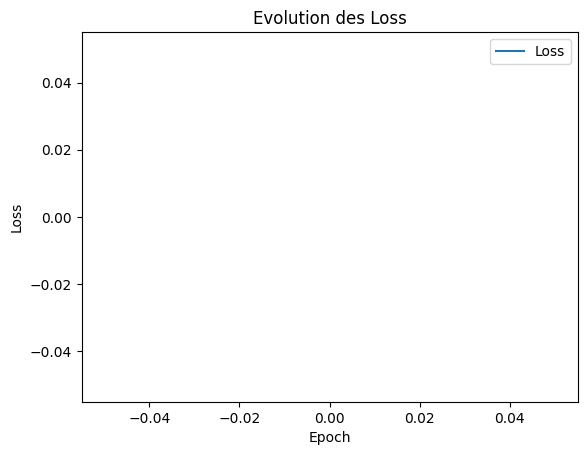

In [ ]:
plot_loss(lin_losses)
# plot_loss_log(lin_losses)
# plot_loss_log(running_mean(lin_losses, 30))

In [ ]:
torch.set_grad_enabled(True)

complex_model.reset_parameters()
complex_model.to(device)

start_rank, start_mrr, start_hits_at_10 = test(test_data, model=complex_model)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train(model=complex_model, optimizer=complex_optimizer)
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data, model=complex_model)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data, model=complex_model)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

100%|██████████| 9001/9001 [00:08<00:00, 1060.76it/s]


Start Test Mean Rank: 1670.75, Start Test MRR: 0.0031, Start Test Hits@10: 0.0037
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6922
Epoch: 004, Loss: 0.6864
Epoch: 005, Loss: 0.6696
Epoch: 006, Loss: 0.6399
Epoch: 007, Loss: 0.6045
Epoch: 008, Loss: 0.5687
Epoch: 009, Loss: 0.5415


100%|██████████| 9001/9001 [00:08<00:00, 1051.08it/s]

Start Test Mean Rank: 1670.75, Start Test MRR: 0.0031, Start Test Hits@10: 0.0037
Final Test Mean Rank: 116.34, Final Test MRR: 0.2197, Final Test Hits@10: 0.4524


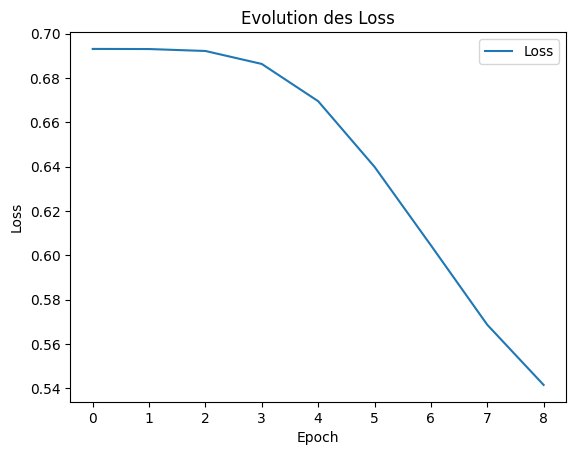

In [ ]:
plot_loss(losses)
# plot_loss_log(losses)
# plot_loss_log(running_mean(losses, 30))

100%|██████████| 9001/9001 [00:08<00:00, 1057.43it/s]


Start Test Mean Rank: 1677.54, Start Test MRR: 0.0026, Start Test Hits@10: 0.0032
error with GO:0008134, GO:2000112
best 9similarities : [0, 0.4730808507746291, 0.4162195371222428, 0.12082110263958337, 0.0, 0.1253719948447181, 0.0, 0.5243011513572068, 0.0]
error with GO:0007112, GO:0000187
best 29similarities : [0.21320446401204227, 0.22830327218817842, 0.0, 0.06113414774810943, 0.0, 0.06213439025195406, 0.0, 0.06246528556529677, 0.0, 0.0, 0.06246528556529677, 0.0, 0.0, 0.0, 0.0, 0.2176818082763797, 0.0, 0.2193191999615509, 0.06133610540879017, 0.06165653260445131, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.21239454173644798, 0.2670793784510481, 0.06129633707213768]
error with GO:0016702, GO:0055114
best 3similarities : [0.6704952727304921, 0.0, 0]
best 10similarities : [0.0, 0.0, 0.0, 0.37921349984661723, 0.0, 0.0, 0.0, 0.0, 0.4504263030334118, 0.0]
best 13similarities : [0.6527999058854599, 0.0, 0.6509762110048672, 0.0, 0.6496399004992278, 0.0, 0.0, 0.49803117667988633, 0.0, 0.0, 0.0, 0.0, 0.0]
b

RuntimeError: grad can be implicitly created only for scalar outputs

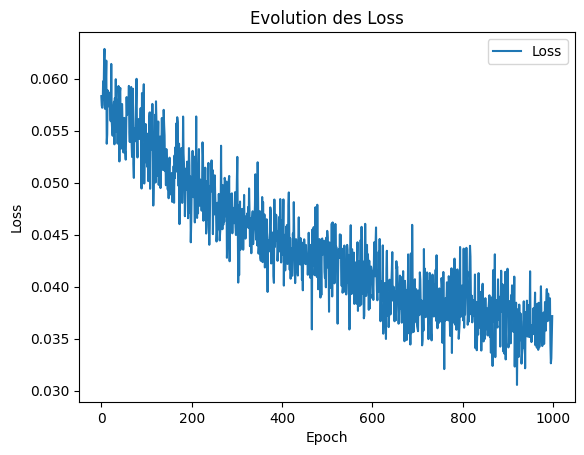

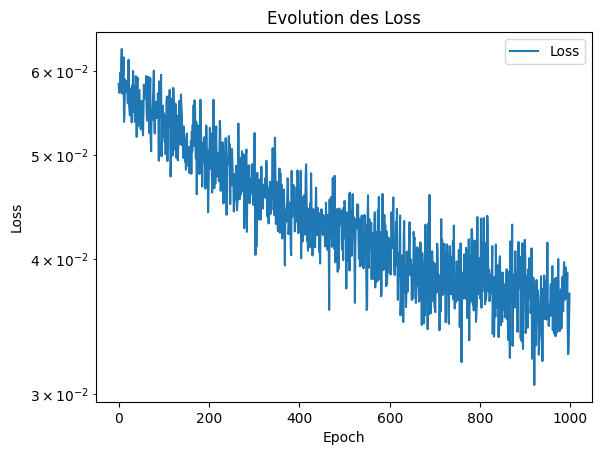

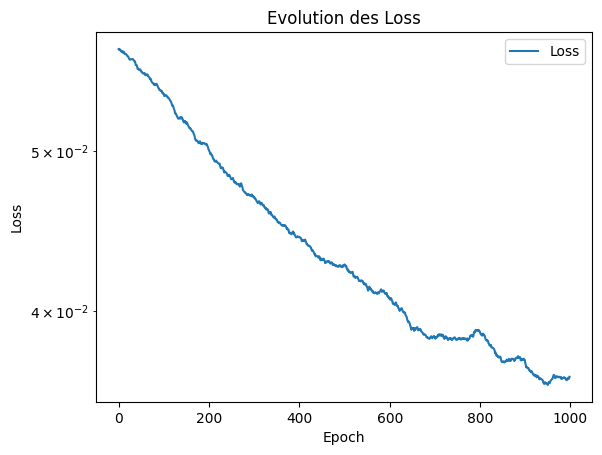